In [ ]:
!python --version

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

import tensorflow as tf
import tensorflow_ranking as tfr

In [2]:
import xml.etree.ElementTree as ET

classes = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

def get_objects(filepath, classes=classes):
    parser = ET.XMLParser(encoding="utf-8")
    targetTree = ET.parse(filepath, parser=parser)
    rootTag = targetTree.getroot()
    res = np.array([[0] * 5])
    for obj in rootTag.findall("object"):
        label_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        res = np.append(
            res,
            np.array([
                [int(bndbox.find("xmin").text),
                 int(bndbox.find("ymin").text),
                 int(bndbox.find("xmax").text),
                 int(bndbox.find("ymax").text),
                 classes[label_name]]
            ]), 
            axis=0)
    return res[1:]

In [3]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

def calculate_detector_score(detector,
                             images_folder="data/HumanPhotos/validation/",
                             annotations_folder="data/HumanPhotos/annotations/"):
    preds = []
    targets = []
    for image_name in os.listdir(images_folder):
        image_path = images_folder + image_name
        annotation_path = annotations_folder + image_name.replace("png", "xml")
        if "png" not in image_name:
            continue
        
        target = get_objects(annotation_path)
        predicted = detector(cv2.imread(image_path))
        dict_target = {
            "boxes": torch.tensor([item[:4] for item in target]),
            "labels":  torch.tensor([0] * len(target))
        }
        targets.append(dict_target)
        dict_pred = {
            "boxes": torch.tensor([item[1:5] for item in predicted]),
            "labels":  torch.tensor([0] * len(predicted)),
            "scores": torch.tensor([1 for item in predicted])
        }
        preds.append(dict_pred)
        
    metric = MeanAveragePrecision()
    metric.update(preds, targets)
    computed = metric.compute()
    pprint(computed)
    return computed 

In [21]:
def cascade_detect_faces(image, cascade, scale=1.1, min_neighbours=3):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    res = cascade.detectMultiScale(grayscale, scale, min_neighbours)
    if len(res) == 0:
        return res
    res[:,2] += res[:,0]
    res[:,3] += res[:,1]
    res = np.insert(res, 0, 1, axis=1)
    return res

def nn_detect_faces(image, model, min_confidence=0.3):
    h, w = image.shape[:2]
    blob=cv2.dnn.blobFromImage(image, 1.0, (300,300), (104.0,177.0,123.0))
    model.setInput(blob)
    detections = model.forward()
    detections = detections[0][0]
    print(detections.shape)
    for i in range(10):
        print(detections[i])
    detections = np.array([det[2:7] for det in detections])
    detections = detections[detections[:,0] >= min_confidence]
    detections[:, 1] *= w
    detections[:, 2] *= h
    detections[:, 3] *= w
    detections[:, 4] *= h
    detections[:, 1:5] = detections[:, 1:5].astype('int')
    return detections

In [5]:
resnetDetector = cv2.dnn.readNet(
    "models/OriginalFaceDetectorNN/res10_300x300_ssd_iter_140000.caffemodel", 
    "deploy.prototxt.txt"
)

In [6]:
cascade_classifiers = [
    cv2.CascadeClassifier(f"models/CascadeClassifiers/classifier_{i}/cascade.xml")
    for i in range(1, 10)
]

default_cascade_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
cascade_classifiers

[< cv2.CascadeClassifier 000001FE9AD66B50>,
 < cv2.CascadeClassifier 000001FE9AD66A90>,
 < cv2.CascadeClassifier 000001FE9AD66A70>,
 < cv2.CascadeClassifier 000001FE9AD66C70>,
 < cv2.CascadeClassifier 000001FE9AD66CF0>,
 < cv2.CascadeClassifier 000001FE9AD66AB0>,
 < cv2.CascadeClassifier 000001FE9AD66A50>,
 < cv2.CascadeClassifier 000001FE9AD66DF0>,
 < cv2.CascadeClassifier 000001FE9AD66C10>]

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.image import resize

def predict_face_class(image, detections, model, image_width):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = []
    real_detections = []
    for detection in detections:
        detection = detection.astype("int")
        detection[1] = max(0, detection[1])
        detection[2] = max(0, detection[2])
        detection[3] = min(image.shape[1], detection[3])
        detection[4] = min(image.shape[0], detection[4])
        if detection[4] <= detection[2] or detection[3] <= detection[1]:
            continue
        real_detections.append(detection)
        face = image[detection[2]: detection[4], detection[1]: detection[3]]
        face = resize(face, (image_width, image_width)) 
        face = preprocess_input(face)
        faces.append(face)
    if len(faces) == 0:
        return np.array([]), np.array([])
    return np.array(real_detections), model.predict(np.array(faces, dtype='float32'), verbose = 0)

def perform_cascade_nn_detect_pipeline(image, cascade, nn, lb, image_width, scale=1.1, min_neighbours=3):
    detections = cascade_detect_faces(image, cascade, scale=scale, min_neighbours=min_neighbours)
    detections, predicted_classes = predict_face_class(image, detections, nn, image_width)
    if len(detections) != 0:
        probs = np.max(predicted_classes, axis=1) / np.sum(predicted_classes, axis=1)
        detections[:, 0] = probs
    predicted_labels = lb.inverse_transform(predicted_classes)
    detections = np.array([detections[i] for i in range(len(detections)) if predicted_labels[i] != "no_face"])
    return detections

def perform_nn_classify_pipeline(image, detections, nn, lb, image_width):
    detections, predicted_classes = predict_face_class(image, detections, nn, image_width)
    if len(predicted_classes) == 0:
        return np.array([]), np.array([]), np.array([])
    probs = np.max(predicted_classes, axis=1) / np.sum(predicted_classes, axis=1)
    
    predicted_labels = lb.inverse_transform(predicted_classes)
    return detections, predicted_labels, probs

def generate_image_with_detections(image, detector, classifier, display_labels = False):
    detections = detector(image)
    detections, predicted_labels, probs = classifier(image, detections)
    for i, detection in enumerate(detections):
        (_, startX,startY,endX,endY) = detection.astype("int")
        face = image[startY:endY, startX:endX]
        if predicted_labels[i] == "no_face":
            continue
        elif predicted_labels[i] == "without_mask":
            color = [0, 0, 255]
        elif predicted_labels[i] == "with_mask":
            color = [0, 255, 0]
        else:
            color = [255, 0, 0]
        if display_labels:
            labelY = max(0, startY - 10)
            cv2.putText(image,
                        f"{probs[i]:.2f}",
                        (startX, labelY),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.45,
                        color,
                        2)
        cv2.rectangle(image, (startX,startY), (endX,endY), color, 2)   
    return image

In [8]:
from tensorflow.keras.models import load_model
from pickle import load

## Load model
face_detect_model = load_model('models/Test/face_detector_nn-64-64-Generated-30-21.hdf5')
lb_detect = load(open('models/Test/label-binarizer-face_detector-2-Generated.pkl', 'rb'))

detectors = {}
for i in range(len(cascade_classifiers)):
    detectors[f"Cascade_{i}"] = lambda img: perform_cascade_nn_detect_pipeline(
        img, 
        cascade_classifiers[i],
        face_detect_model,
        lb_detect,
        64,
        scale=1.05
    )
    
detectors["Cascade_Default"] = lambda img: perform_cascade_nn_detect_pipeline(
    img, 
    default_cascade_classifier,
    face_detect_model,
    lb_detect,
    64,
    scale=1.05
)

detectors["Cascade_Default_No_Detector"] = lambda img: cascade_detect_faces(
    img, 
    default_cascade_classifier,
    scale=1.05
)


detectors["ResNet"] = lambda img: nn_detect_faces(img, resnetDetector)

detectors.keys()

dict_keys(['Cascade_0', 'Cascade_1', 'Cascade_2', 'Cascade_3', 'Cascade_4', 'Cascade_5', 'Cascade_6', 'Cascade_7', 'Cascade_8', 'Cascade_Default', 'Cascade_Default_No_Detector', 'ResNet'])

In [9]:
detector_results = []
for name, det in detectors.items():
    print("Detector:", name)
    detector_results.append(calculate_detector_score(det))

Detector: Cascade_0


c:\users\sonia\desktop\facemask_detection\test\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


KeyboardInterrupt: 

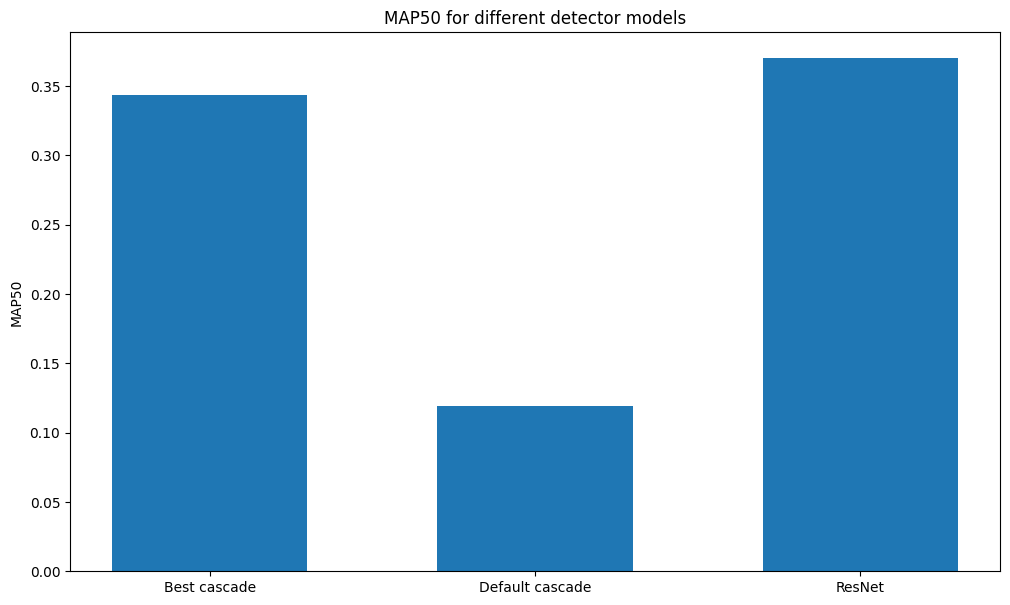

In [28]:
map_50 = np.array([float(det["map_50"]) for det in detector_results])

labels = ('Best cascade', 'Default cascade', 'ResNet')
counts = (np.max(map_50[:len(cascade_classifiers)]), map_50[-2], map_50[-1])
plt.figure(figsize=(12, 7))
plt.bar(labels, counts, 0.6, bottom=np.zeros(len(counts)))
plt.ylabel("MAP50")
plt.title('MAP50 for different detector models')
plt.savefig("images/map_50-different_models.svg")
plt.show()


In [9]:
mask_classify_model_faces = load_model('models/Test/mask_classifier_nn-96-96-Faces-30-29.hdf5')
lb_faces = load(open('models/Test/label-binarizer-mask_classifier-3-Faces.pkl', 'rb'))

mask_classify_model_FMD = load_model('models/Test/mask_classifier_nn-96-96-FMD-30-30.hdf5')
lb_FMD = load(open('models/Test/label-binarizer-mask_classifier-3-FMD.pkl', 'rb'))

classifiers = {
    "NN_Faces": lambda img, detections: perform_nn_classify_pipeline(
        img, 
        detections,
        mask_classify_model_faces, 
        lb_faces,
        96
    ),
    "NN_FMD": lambda img, detections: perform_nn_classify_pipeline(
        img,
        detections,
        mask_classify_model_FMD,
        lb_FMD, 
        96
    ),
    
}
classifiers.keys()

dict_keys(['NN_Faces', 'NN_FMD'])

In [14]:
classifier_name = "NN_Faces"
detector_name = "ResNet"

detector = detectors[detector_name]
classifier = classifiers[classifier_name]

(200, 7)
[0.         1.         0.99916863 0.6659773  0.22220057 0.801449
 0.47526097]
[0.         1.         0.9790319  0.34708413 0.23904648 0.45520517
 0.4758905 ]
[0.         1.         0.8734611  0.49654683 0.18424278 0.61112034
 0.44301873]
[0.         1.         0.7590346  0.19884703 0.31756043 0.2961271
 0.57141805]
[0.         1.         0.2457016  0.60131717 0.00656292 0.7220576
 0.2520448 ]
[0.         1.         0.12772678 4.168301   4.005169   4.8406625
 4.986003  ]
[0.         1.         0.1224691  0.16094092 4.0027237  0.83162165
 4.988818  ]
[0.         1.         0.11462294 0.1992999  0.52994585 0.24657962
 0.6453476 ]
[0.         1.         0.11367718 4.1677084  0.02522811 4.835574
 0.9841162 ]
[0.         1.         0.10777014 0.1649687  0.01902485 0.83208203
 0.98387957]


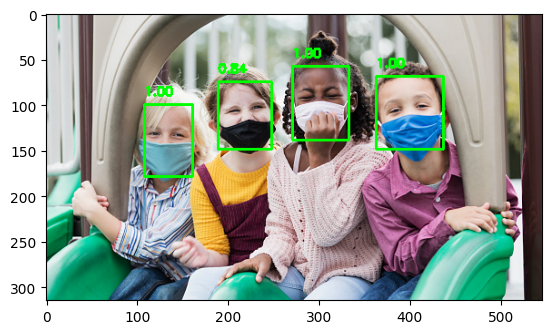

In [22]:
path = "data/demo-images/childern-with-mask.jpg"
image = cv2.imread(path)
image = generate_image_with_detections(image, detector, classifier, display_labels=True)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [30]:
cap = cv2.VideoCapture("data/Videos/mask-video.mp4") 
start_frame = 1000

if not cap.isOpened(): 
    print("Error opening video file") 

while cap.isOpened():  
    ret, frame = cap.read()
    start_frame = max(0, start_frame - 1)
    if start_frame > 0:
        continue
    frame = generate_image_with_detections(frame, detector, classifier)
    if ret:  
        cv2.imshow('Frame', frame) 
          
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break 

cap.release()  
cv2.destroyAllWindows()

In [31]:
from imutils.video import VideoStream
import imutils

vs = VideoStream(src=0).start()

while True:  
    frame=vs.read()
    frame=imutils.resize(frame, width=400)
    frame = generate_image_with_detections(frame, detector, classifier, display_labels=True)      
    cv2.imshow('Frame', frame) 
          
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break 

cv2.destroyAllWindows()
vs.stop()

In [1]:
from memory_profiler import memory_usage
import time

test_folder = "data/demo-images/"
total_time = 0
total_files = 0
files = os.listdir(test_folder)
for file in files:
    if ".png" not in file and ".jp" not in file:
        continue
    total_files += 1
    image = cv2.imread(f"{test_folder}{file}")
    image = cv2.resize(image, (300, 300))
    start = time.time()
    detections = detector(image)
    detections, predicted_labels, probs = classifier(image, detections)
    total_time += time.time() - start
    print(total_time)
total_time, total_files

NameError: name 'os' is not defined

In [43]:
from imutils import paths
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def create_dataset(labels, labels_folders, image_size):
    data = []
    labels_names=[]
    for i, folder in enumerate(labels_folders):
        image_paths = list(paths.list_images(folder))
        labels_names += [labels[i]] * len(image_paths)
        for path in image_paths:
            image = load_img(path, target_size=(image_size, image_size))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
    data = np.array(data, dtype='float32')
    labels_names = np.array(labels_names)
    return data, labels_names

def plot_confusion_matrix(model, data_X, data_Y, lb, output_file=None):
    predict=model.predict(data_X, batch_size=32)
    predict=lb.inverse_transform(predict)
    expected = lb.inverse_transform(data_Y)
    matrix = confusion_matrix(expected, predict, labels=lb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=lb.classes_)
    disp.plot()
    if output_file is not None:
        plt.savefig(output_file, bbox_inches="tight")
        
def create_classification_report(model, data_X, data_Y, lb):
    predict = model.predict(data_X, batch_size = 32, verbose = 0)
    predict = lb.inverse_transform(predict)
    expected = lb.inverse_transform(data_Y)
    return classification_report(expected, predict, target_names=lb.classes_)

In [15]:
data_faces, labels_faces = create_dataset(["mask_weared_incorrect",
                                           "without_mask", 
                                           "with_mask"],
                                          ["data/Faces/mask_weared_incorrect",
                                           "data/Faces/without_mask/",
                                           "data/Faces/with_mask/"],
                                          96)

labels_faces = lb_faces.transform(labels_faces)
data_faces.shape

(8982, 96, 96, 3)

In [22]:
from sklearn.model_selection import train_test_split

train_faces_X, test_faces_X, train_faces_Y, test_faces_Y = train_test_split(
    data_faces,
    labels_faces,
    test_size=0.20,
    random_state=10,
    stratify=labels_faces
)

In [23]:
train_faces_X.shape

(7185, 96, 96, 3)

In [17]:
data_detect, labels_detect = create_dataset(["face",
                                             "no_face"],
                                            ["data/FacesDetectionGenerated/Face/",
                                             "data/FacesDetectionGenerated/No_Face/"],
                                             64)
labels_detect = lb_detect.transform(labels_detect)
data_detect.shape

(5835, 64, 64, 3)

In [24]:
train_detect_X, test_detect_X, train_detect_Y, test_detect_Y = train_test_split(
    data_detect,
    labels_detect,
    test_size=0.20,
    random_state=10,
    stratify=labels_detect
)

In [25]:
train_detect_X.shape

(4668, 64, 64, 3)

In [19]:
data_FMD, labels_FMD = create_dataset(["mask_weared_incorrect",
                                       "without_mask",
                                       "with_mask"],
                                      ["data/FMD_DATASET/incorrect_mask/",
                                       "data/FMD_DATASET/without_mask/",
                                       "data/FMD_DATASET/with_mask/"],
                                     96)
labels_FMD = lb_FMD.transform(labels_FMD)
data_FMD.shape

c:\users\sonia\desktop\facemask_detection\test\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(14536, 96, 96, 3)

In [26]:
train_FMD_X, test_FMD_X, train_FMD_Y, test_FMD_Y = train_test_split(
    data_FMD,
    labels_FMD,
    test_size=0.20,
    random_state=10,
    stratify=labels_FMD
)

In [27]:
train_FMD_X.shape

(11628, 96, 96, 3)

225/225 [==============================] - 17s 75ms/step


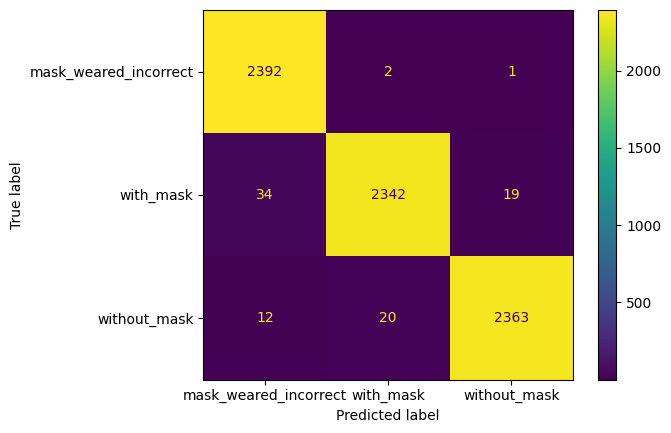

In [36]:
plot_confusion_matrix(
    mask_classify_model_faces,
    train_faces_X,
    train_faces_Y,
    lb_faces,
    output_file="images/confusion_matrix-train-mask_classifier-Faces.png"
)

364/364 [==============================] - 28s 77ms/step


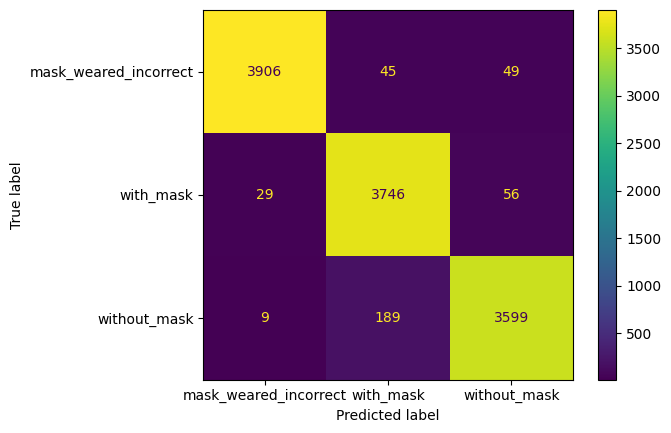

In [37]:
plot_confusion_matrix(
    mask_classify_model_FMD,
    train_FMD_X,
    train_FMD_Y,
    lb_FMD,
    output_file="images/confusion_matrix-train-mask_classifier-FMD.png"
)

146/146 [==============================] - 5s 33ms/step


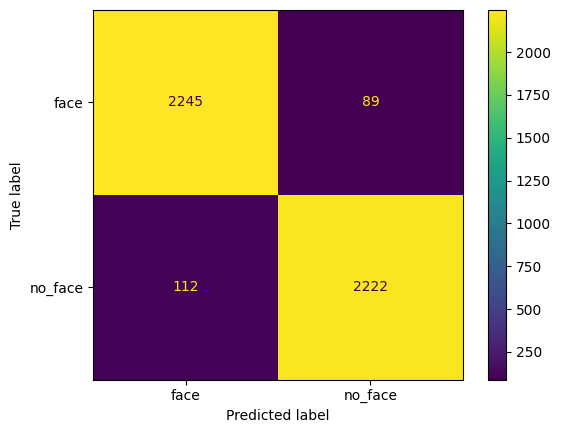

In [38]:
plot_confusion_matrix(
    face_detect_model,
    train_detect_X,
    train_detect_Y,
    lb_detect,
    output_file="images/confusion_matrix-train-face_detector.png"
)

In [44]:
print("Classification report for NN classificator trained on Faces dataset (validation data)")
print(create_classification_report(mask_classify_model_faces, test_faces_X, test_faces_Y, lb_faces))

Classification report for NN classificator trained on Faces dataset (validation data)
                       precision    recall  f1-score   support

mask_weared_incorrect       0.98      0.99      0.99       599
            with_mask       0.98      0.97      0.98       599
         without_mask       0.98      0.98      0.98       599

             accuracy                           0.98      1797
            macro avg       0.98      0.98      0.98      1797
         weighted avg       0.98      0.98      0.98      1797



In [45]:
print("Classification report for NN classificator trained on Faces dataset (train data)")
print(create_classification_report(mask_classify_model_faces, train_faces_X, train_faces_Y, lb_faces))

Classification report for NN classificator trained on Faces dataset (train data)
                       precision    recall  f1-score   support

mask_weared_incorrect       0.98      1.00      0.99      2395
            with_mask       0.99      0.98      0.98      2395
         without_mask       0.99      0.99      0.99      2395

             accuracy                           0.99      7185
            macro avg       0.99      0.99      0.99      7185
         weighted avg       0.99      0.99      0.99      7185



In [46]:
print("Classification report for NN classificator trained on FMD dataset (validation data)")
print(create_classification_report(mask_classify_model_FMD, test_FMD_X, test_FMD_Y, lb_FMD))

Classification report for NN classificator trained on FMD dataset (validation data)
                       precision    recall  f1-score   support

mask_weared_incorrect       0.99      0.97      0.98      1000
            with_mask       0.93      0.96      0.94       958
         without_mask       0.96      0.94      0.95       950

             accuracy                           0.96      2908
            macro avg       0.96      0.96      0.96      2908
         weighted avg       0.96      0.96      0.96      2908



In [47]:
print("Classification report for NN classificator trained on FMD dataset (train data)")
print(create_classification_report(mask_classify_model_FMD, train_FMD_X, train_FMD_Y, lb_FMD))

Classification report for NN classificator trained on FMD dataset (train data)
                       precision    recall  f1-score   support

mask_weared_incorrect       0.99      0.98      0.98      4000
            with_mask       0.94      0.98      0.96      3831
         without_mask       0.97      0.95      0.96      3797

             accuracy                           0.97     11628
            macro avg       0.97      0.97      0.97     11628
         weighted avg       0.97      0.97      0.97     11628



In [48]:
print("Classification report for NN face detector (validation data)")
print(create_classification_report(face_detect_model, test_detect_X, test_detect_Y, lb_detect))

Classification report for NN face detector (validation data)
              precision    recall  f1-score   support

        face       0.95      0.97      0.96       584
     no_face       0.97      0.94      0.96       583

    accuracy                           0.96      1167
   macro avg       0.96      0.96      0.96      1167
weighted avg       0.96      0.96      0.96      1167



In [49]:
print("Classification report for NN face detector (train data)")
print(create_classification_report(face_detect_model, train_detect_X, train_detect_Y, lb_detect))

Classification report for NN face detector (train data)
              precision    recall  f1-score   support

        face       0.95      0.96      0.96      2334
     no_face       0.96      0.95      0.96      2334

    accuracy                           0.96      4668
   macro avg       0.96      0.96      0.96      4668
weighted avg       0.96      0.96      0.96      4668



[3.7673146e-01 2.4200000e+02 1.9400000e+02 3.0100000e+02 4.0000000e+02]


TypeError: slice indices must be integers or None or have an __index__ method

NameError: name 'detection' is not defined